# TP1 : régression et propagation d'incertitudes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

ModuleNotFoundError: No module named 'torch'

Ce TP a pour but d'utiliser différentes méthodes d'approximation pour 
interpoler des solutions obtenues par différences finies et étudier un problème de propagation d'incertitude.

On considère le problème de Poisson suivant : 
$$
\left\{\begin{array}{l}
- u''(x) =f, \quad \forall x\in ]0,1[\\
u(0)=u(1)=0,\end{array}\right.
$$
où $u : [0,1] \to \R$ est l'inconnue du problème et $f : [0,1] \to \R$ une fonction donnée.

Pour résoudre cette équation, on utilise une méthode de type différence finie. On considère donc une subdivision régulière $0 = x_0 \leq \ldots \leq x_{J+1}$ de l'intervalle $[0,1]$, avec $J \in \N^\ast$, $\Delta x = 1/J$ et $x_j = j \Delta x$ pour $j = 0,\ldots, J+1$. On cherche une solution approchée $u_j \approx u(x_j)$, pour $j = 1,\ldots, J$. Pour cela, on considère le schéma suivant
$$
\frac{-u_{j+1}+2u_j-u_{j-1}}{\Delta x^2} =f(x_j),\quad \forall j \in \{1,\ldots, J\}$$ 
$$ u_0=u_{J+1}=0
$$
qui se met sous forme matricielle $A u = b$.

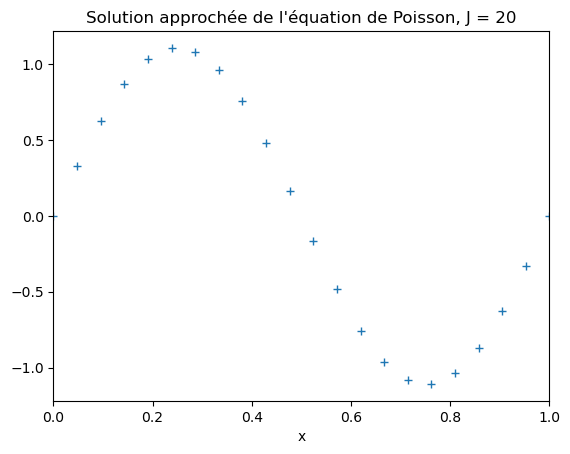

In [15]:
def matrix_poisson( J):
    dx = 1/J
    A = np.diag([2.]*J) + np.diag([-1]*(J-1), k=1) + np.diag([-1]*(J-1), k=-1) 
    A /= dx**2
    return A

def solve_poisson(J, f):
    mesh = np.linspace(0, 1, J+2)
    A = matrix_poisson( J)

    b = f(mesh[1:-1])
    u = np.zeros_like(mesh)
    u[1:-1] = np.linalg.solve(A, b)
    return mesh, u

J = 20
f = lambda x : 4.0 * (np.pi**2.0)*np.sin(2.0*np.pi*x)
mesh, u = solve_poisson( J, f)

plt.plot(mesh, u, '+')
plt.xlim([0,1])
plt.xlabel('x')
plt.title("Solution approchée de l'équation de Poisson, J = "+str(J));

### Partie 1 - Régression

1. Programmer une méthode de régression polynomiale pour interpoler la solution approchée sur un maillage composé de $200$ points. Comparer le résultat obtenu en comparant avec la solution exacte.


2. Reprennez la question précédente en utilisant la méthode de régression à noyau avec un noyau radial Gaussien $k(x,y) = \exp(- ||x-y||^2 / (2\ell^2))$.

2. Reprenez le même exercice avec un réseau de neurones de type dense (multi-layer perceptron).

In [9]:
class mlp(torch.nn.Module):
    def __init__(self, layer_widths = list):
        super().__init__()

        self.layer_widths = layer_widths
        
        self.hidden_layers = []
        for i in range( len(layer_widths)-1):
            self.hidden_layers.append(torch.nn.Linear(self.layer_widths[i], self.layer_widths[i+1], dtype=torch.double))

        self.hidden_layers = torch.nn.ModuleList(self.hidden_layers)
        self.activation = torch.nn.Tanh()

    def forward(self, inputs):
        for i in range( len(self.layer_widths)-1):
                inputs = self.activation(self.hidden_layers[i].forward(inputs))
        return inputs


In [13]:
#model = 
#optimizer = torch.optim.Adam(model.parameters())
#nb_epochs = 400

#x_train = 
#y_train = 

#for epoch in range( nb_epochs):
#    optimizer.zero_grad()
#    y_pred = model(x_train)
#    loss = 
#    loss.backward()
#    optimizer.step()

#print("epoch "+ str(epoch)+': '+str(loss.item()))

### Partie 2 - propagation d'incertitudes

Supposons que l'on ne connaisse pas exactement la fonction $f(x)$. Celui peut être modélisé par un processus Gaussien avec un noyau de type radial Gaussien: c'est donc une fonction aléatoire. Par ailleurs, nous l'ajustons de sorte à ce qu'il passe par certaines valeurs ponctuelles $(f_i)_{i=1,\ldots m}$ en certains points $(y_i)_{i=1,\ldots m}$: nous obtenons ainsi une probabilité condtionnelle à cet évènement.

Etant donné cette incertitude sur $f$, on voudrait connaitre celle sur $u$.

1. A l'aide de scikit-learn, ajuster un processus gaussien en supposant qu'il passe par $m$ points $(y_1,\sin(2\pi y_1)+\varepsilon_1),\ldots,(y_m,\sin(2\pi y_m)+\varepsilon_m)$ et afficher le. 

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


#plt.plot(fine_mesh, mean_prediction, label="Mean prediction")
#plt.fill_between(
#    fine_mesh.ravel(),
#    mean_prediction - 1.96 * std_prediction,
#    mean_prediction + 1.96 * std_prediction,
#    alpha=0.5,
#    label=r"95% confidence interval",
#    );
#plt.legend(loc='best');

2. A partir de cette loi, échantillonner $n$ seconds membres discrets $(f_i)$ et calculer les solutions approchées associées. 

3. Calculer la moyenne et l'écart type des solutions approchées à l'aide des estimateurs statistiques : 
$$
E[u]=\frac{1}{n}\sum_{i=1}^n\mathbf{u}_i, \quad Var(u)=\frac{1}{n}\sum_{i=1}^n(\mathbf{u}_i-E[u])^2
$$
Afficher ensuite le résultat.